In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import regularizers
from keras.models import load_model
from scipy.io.arff import loadarff 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

os.environ["OMP_NUM_THREADS"] = '1'


print(
"TensorFlow version:", tf.__version__)
print("Num GPUs Available", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.17.0
Num GPUs Available 0


In [3]:
raw_data = loadarff('dataset.arff')
df = pd.DataFrame(raw_data[0])
df.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


In [23]:
# Assuming your dataset is in a DataFrame called `df`
# and the 'fraud' column contains the target values.

# Number of samples we want in the final dataset
target_size = 25000

# Separate the dataset into two classes
fraud_0 = df[df['fraud'] == 0.0]
fraud_1 = df[df['fraud'] == 1.0]

# Calculate the maximum samples we can take from each class
max_samples_per_class = min(len(fraud_0), len(fraud_1))

# Calculate the number of samples needed for each class, ensuring it does not exceed the maximum
samples_per_class = min(target_size // 2, max_samples_per_class)

# Randomly sample from each class
fraud_0_sample = fraud_0.sample(n=samples_per_class, random_state=42)
fraud_1_sample = fraud_1.sample(n=samples_per_class, random_state=42)

# Combine the samples
df_balanced = pd.concat([fraud_0_sample, fraud_1_sample])

# Shuffle the dataset to mix classes well
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Now `df_balanced` is your balanced and reduced dataset.

In [17]:
X = df_balanced.drop(columns=['fraud'])
y = df_balanced['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
dropout_rate = 0.3

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(500, activation='relu', input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(250, activation='relu'))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(125, activation='relu'))
model.add(tf.keras.layers.Dropout(dropout_rate))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

model.fit(X_train, y_train, epochs=50, batch_size=10, class_weight=class_weights_dict)

Epoch 1/50
400/400 [==============================] - 1s 2ms/step - loss: 0.1653 - accuracy: 0.9452
Epoch 2/50
400/400 [==============================] - 1s 2ms/step - loss: 0.0998 - accuracy: 0.9632
Epoch 3/50
400/400 [==============================] - 1s 2ms/step - loss: 0.0758 - accuracy: 0.9730
Epoch 4/50
400/400 [==============================] - 1s 2ms/step - loss: 0.0639 - accuracy: 0.9760
Epoch 5/50
400/400 [==============================] - 1s 2ms/step - loss: 0.0606 - accuracy: 0.9790
Epoch 6/50
400/400 [==============================] - 1s 2ms/step - loss: 0.0521 - accuracy: 0.9803
Epoch 7/50
400/400 [==============================] - 1s 2ms/step - loss: 0.0528 - accuracy: 0.9825
Epoch 8/50
400/400 [==============================] - 1s 2ms/step - loss: 0.0455 - accuracy: 0.9810
Epoch 9/50
400/400 [==============================] - 1s 2ms/step - loss: 0.0471 - accuracy: 0.9825
Epoch 10/50
400/400 [==============================] - 1s 2ms/step - loss: 0.0394 - accuracy: 0.9860

In [19]:
model.save('best_model_small_50-50.h5')

In [20]:
X = df.drop(columns=['fraud'])
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# Load the model
loaded_model = load_model('model_50-50.h5')

# Make predictions (outputs probabilities between 0 and 1)
y_pred_probs = loaded_model.predict(X_test)

# Convert probabilities to binary class predictions (0 or 1)
y_pred_classes = (y_pred_probs >= 0.9).astype(int).reshape(-1)

# Print the classification report
print("classification_report: \n", classification_report(y_test, y_pred_classes))
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print(conf_matrix)

6250/6250 [==============================] - 4s 710us/step
classification_report: 
               precision    recall  f1-score   support

         0.0       1.00      0.85      0.92    182557
         1.0       0.38      1.00      0.55     17443

    accuracy                           0.86    200000
   macro avg       0.69      0.92      0.73    200000
weighted avg       0.95      0.86      0.88    200000

[[154273  28284]
 [     0  17443]]


Classification Report at threshold 0.1:
               precision    recall  f1-score   support

         0.0       1.00      0.81      0.90    182557
         1.0       0.34      1.00      0.50     17443

    accuracy                           0.83    200000
   macro avg       0.67      0.91      0.70    200000
weighted avg       0.94      0.83      0.86    200000



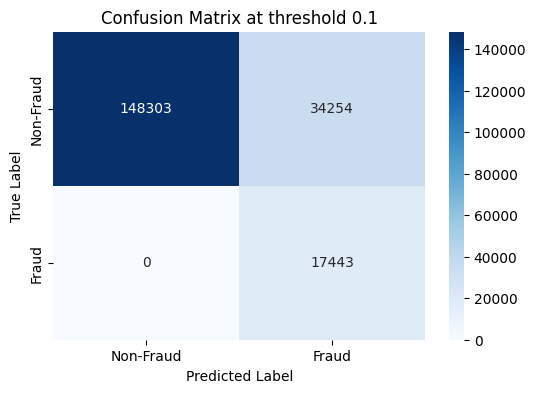

Classification Report at threshold 0.3:
               precision    recall  f1-score   support

         0.0       1.00      0.82      0.90    182557
         1.0       0.35      1.00      0.52     17443

    accuracy                           0.84    200000
   macro avg       0.67      0.91      0.71    200000
weighted avg       0.94      0.84      0.87    200000



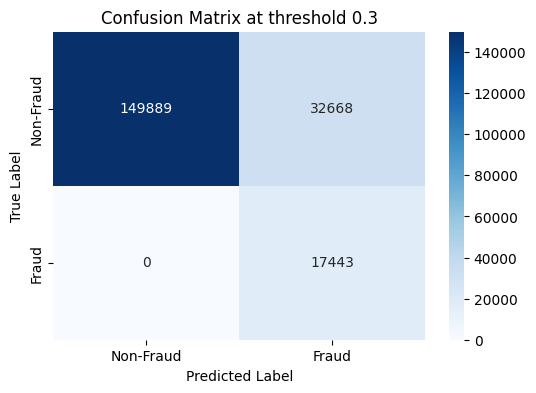

Classification Report at threshold 0.5:
               precision    recall  f1-score   support

         0.0       1.00      0.83      0.91    182557
         1.0       0.36      1.00      0.52     17443

    accuracy                           0.84    200000
   macro avg       0.68      0.91      0.71    200000
weighted avg       0.94      0.84      0.87    200000



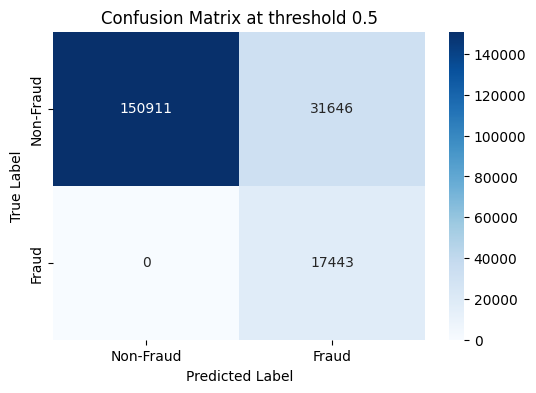

Classification Report at threshold 0.7:
               precision    recall  f1-score   support

         0.0       1.00      0.83      0.91    182557
         1.0       0.37      1.00      0.54     17443

    accuracy                           0.85    200000
   macro avg       0.68      0.92      0.72    200000
weighted avg       0.94      0.85      0.88    200000



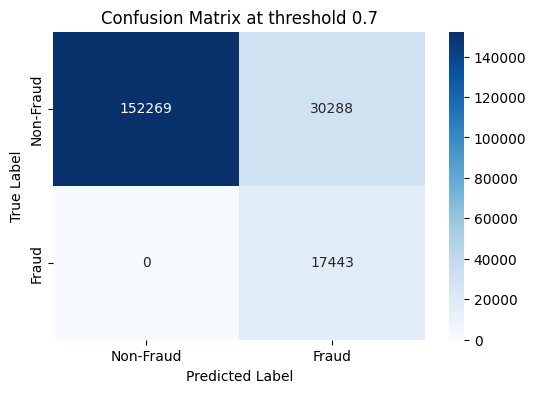

Classification Report at threshold 0.9:
               precision    recall  f1-score   support

         0.0       1.00      0.85      0.92    182557
         1.0       0.38      1.00      0.55     17443

    accuracy                           0.86    200000
   macro avg       0.69      0.92      0.73    200000
weighted avg       0.95      0.86      0.88    200000



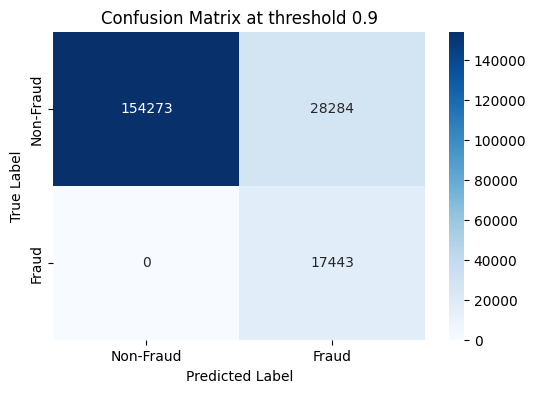

In [28]:
def evaluate_at_threshold(threshold):
    # Convert probabilities to binary class predictions using the given threshold
    y_pred_classes = (y_pred_probs >= threshold).astype(int).reshape(-1)

    # Print the classification report
    print(f"Classification Report at threshold {threshold}:\n", classification_report(y_test, y_pred_classes))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix at threshold {threshold}')
    plt.show()

    return conf_matrix

# Test different thresholds: 0.1, 0.3, 0.5, 0.7, 0.9
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9]:
    evaluate_at_threshold(threshold)